In [1]:
# Imports
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment and creates mini batches
import torchvision
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
from sklearn.model_selection import train_test_split
import numpy as np


from gtzan import GtzanData
from gtzan import GtzanDataset

In [2]:
GTZAN = GtzanData()

2


/Users/somaf/anaconda3/lib/python3.7/site-packages/librosa/filters.py:196: FutureWarning: norm=1 behavior will change in librosa 0.8.0. To maintain forward compatibility, use norm='slaney' instead.
  FutureWarning)
0it [00:00, ?it/s]

Tests created:  (2, 80, 911) (2,)
[[ -9.529814  -12.923529  -15.536166  ...   8.219596    4.9633436
    4.182333 ]
 [ -5.5321817  -8.261785   -1.795187  ...   9.761513    8.360032
    7.964115 ]
 [ -1.3627292  -1.8193327   9.788348  ...   8.355258    3.3490143
    2.3999622]
 ...
 [-20.013609  -19.097206  -18.188871  ...  -2.6430554  -5.209298
   -9.0381155]
 [-21.304207  -22.136421  -18.765451  ...  -4.4718637  -5.995268
   -9.590889 ]
 [-27.923512  -28.76905   -30.377396  ... -10.538172  -13.197453
  -16.176437 ]]
Entering set_up_buckets loop
num of iterations: 18


18it [00:10,  1.83it/s]
0it [00:00, ?it/s]

18 [7, 6, 3, 4, 4, 6, 4, 3, 8, 5, 0, 2, 2, 9, 2, 4, 6, 0]
[[ 12.95991    10.857708    6.364647  ... -17.839642  -19.684824
  -18.53613  ]
 [  9.164498    7.5333924   4.2772636 ... -14.14283   -14.837526
  -14.996873 ]
 [  6.7404957   1.5253916  -5.9684486 ... -12.213085  -14.493652
  -15.932869 ]
 ...
 [-16.606863  -16.372793  -12.685412  ...  -6.58186   -11.528234
  -15.970807 ]
 [-18.657738  -17.741966  -15.305676  ...  -9.944855  -14.369799
  -16.33788  ]
 [-22.891968  -24.419662  -25.40763   ... -20.077194  -23.182072
  -24.204773 ]]
Entering init_dataframe loop
noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


1it [00:09,  9.48s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


2it [00:19,  9.55s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


3it [00:29,  9.77s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


4it [00:39,  9.85s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


5it [00:50, 10.09s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


6it [01:00, 10.11s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


7it [01:10, 10.11s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


8it [01:20, 10.12s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


9it [01:30, 10.13s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


10it [01:40, 10.13s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


11it [01:51, 10.15s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


12it [02:01, 10.11s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


13it [02:11, 10.12s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


14it [02:21, 10.14s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


15it [02:31, 10.09s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


16it [02:41, 10.04s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


17it [02:50,  9.90s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


18it [03:00,  9.79s/it]

(198, 80, 911) (198,)


In [3]:
GTZAN.train_y

array([7, 6, 3, 4, 4, 6, 4, 3, 8, 5, 0, 2, 2, 9, 2, 4, 6, 0, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)
train_dataset = GtzanDataset(GTZAN.train_x, GTZAN.train_y, transform=transform)
test_dataset = GtzanDataset(GTZAN.test_x, GTZAN.test_y, transform=transform)

In [5]:
train_loader = DataLoader(dataset=train_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels: tensor([7])


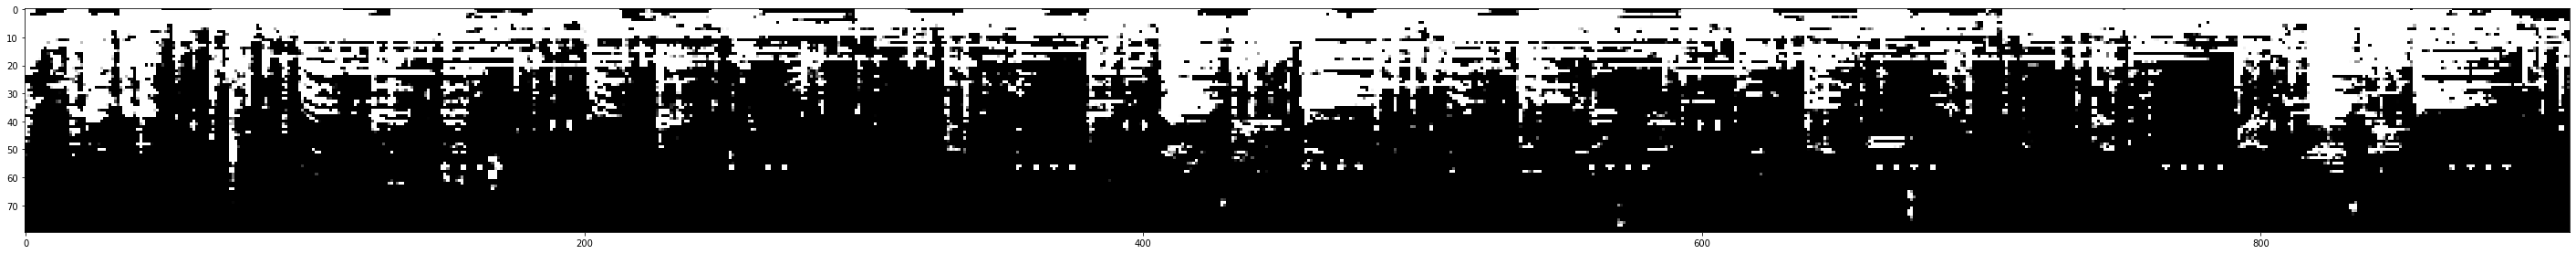

In [6]:
import matplotlib.pyplot as plt
batch = next(iter(train_loader))
spectrograms, labels = batch
grid = torchvision.utils.make_grid(spectrograms, nrow=10)

plt.figure(figsize=(50,100))
plt.imshow(grid.permute(1,2,0))

print('labels:', labels)


In [7]:
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=64,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(
            in_channels=64,
            out_channels=64,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.fc1 = nn.Linear(260352, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)

        return x


In [8]:
print(torch.cuda.is_available())

False


In [9]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
in_channel = 1
num_classes = 10
learning_rate = 0.001
batch_size = 1
num_epochs = 5

# Initialize network
model = CNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Lets train it

In [10]:
# Train Network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()


In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )

    model.train()

In [ ]:
test_dataset.X

In [ ]:
print("Checking accuracy on training data")
check_accuracy(train_loader, model)

print("Checking accuracy on test data")
check_accuracy(test_loader, model)